In [76]:
# Import libraries:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from pathlib import Path

In [10]:
# Set relative path to data:
path_to_data = '../data'

### Load data

We have simulated temperatur fluxes from a coarse grained simulation with $40km$ resolution. Data is provided on a FESOM grid. Furthermore, we have simulated temperatur fluxes from a fine grained simulation with $10km$ resolution as ground truth data. This ground truth data can be aggregated to a $40km$ resolution as a third data set, which still contains effects from the fine grained simulation and thus, carries more information compared to the raw coarse grained simulation.

As target, we aim to infer these aggregated temperature fluxes on a $40km$ resolution.

In a first step, we plan to use Rossby radius $R_D$, buoyancy frequency $N^2$ and isopycnal slopes $S_x$ and $S_y$ as input parameters. Additionally, we intend to use simulated temperatur fluxes $u'T'$ and $v'T'$ from the raw coarse grained simulation with $40km$ resolution as input.

**Note:** So far, we don't have all data, yet. Until we have the final data, we need to work with dummy data in this tutorial. This means, we only have certain parameters and work with an extract in time and only consider a limited number of vertical levels, for illustration purposes.

In [37]:
## Load dummy data and convert to DataArray:

# Slopes S_x and S_y, used as input data:
slope_x = xr.open_dataset(Path(path_to_data + '/input_slope_x.nc')).to_array()
slope_y = xr.open_dataset(Path(path_to_data + '/input_slope_y.nc')).to_array()

# Temperatur flux u*T in x- and y- direction, referred to as flux_u and and flux_y, respectively, used as targets:
flux_u = xr.open_dataset(Path(path_to_data + '/output_uflux.nc')).to_array()
flux_v = xr.open_dataset(Path(path_to_data + '/output_vflux.nc')).to_array()

# Check dimensions:
print('slope_x shape (variables, timesteps, vert. levels, nodes): ',slope_x.shape)
print('slope_y shape (variables, timesteps, vert. levels, nodes): ',slope_y.shape)
print('flux_u shape (variables, timesteps, vert. levels, nodes): ',flux_u.shape)
print('flux_v shape (variables, timesteps, vert. levels, nodes): ',flux_v.shape)

slope_x shape (variables, timesteps, vert. levels, nodes):  (1, 50, 3, 11450)
slope_y shape (variables, timesteps, vert. levels, nodes):  (1, 50, 3, 11450)
flux_u shape (variables, timesteps, vert. levels, nodes):  (1, 50, 3, 11450)
flux_v shape (variables, timesteps, vert. levels, nodes):  (1, 50, 3, 11450)


### Preprocess data

This block serves as a placeholder. Until we have the final data, we skip parts of the preprocessing. In particular, we do not care about normalization and/or scaling of input and target data.

In the first step, we only have isopycnal slopes in x- and y-direction ($S_x$ and $S_y$) as input data to predict temperature fluxes $u'T'$ and $v'T'$. Thus, we have two input and two output channels (or "features").

As baseline, we set up a number of multilayer perceptron (MLP) models, one model for each vertical level.
And to keep it as simple as possible, we have a one-to-one relation for each grid point at a certain timestep. In other words, to predict temperature fluxes for a certain grid point and timestep, we restrict ourselves to only use input information for that specific grid point at that specific timestep. (As an extension, we may allow spatially neighboring grid points' information to be involved as additional input information and/or consider current ($t=0$) plus a certain number $N$ of past timesteps ($t<0$) to improve our prediction.)

In this baseline szenario with a one-to-one relation, each grid point can be treated as an individual sample and we can flatten the time dimension. This gives us $50 \cdot 11450$ (= number of timesteps times number of grid points) input samples for each of the $3$ vertical levels. 

Usually, the input data is split into training, validation and test data. Training data serves for training the model. Validation data is needed for tuning any hyperparameters. Ultimately, test data is only used for model evaluation. For simplicity, we use 30 / 10 / 10 timesteps for training / validation / test data.

In [75]:
## Prepare training, validation and test data for inputs and targets:

# As an example, extract data for the first vertical level (v1):
slope_x_v1 = slope_x[:,:,0,:]
slope_y_v1 = slope_y[:,:,0,:]
flux_u_v1 = flux_u[:,:,0,:]
flux_v_v1 = flux_v[:,:,0,:]

# Concatenate inputs and targets, to have two channels, each:
input_v1_concat = np.concatenate([slope_x_v1,slope_y_v1], axis=0)
target_v1_concat = np.concatenate([flux_u_v1,flux_v_v1], axis=0)

# Split inputs and targets into training, validation and test sets:
train_input_v1_concat = input_v1_concat[:,:30,:]
val_input_v1_concat = input_v1_concat[:,30:40,:]
test_input_v1_concat = input_v1_concat[:,40:,:]
train_target_v1_concat = target_v1_concat[:,:30,:]
val_target_v1_concat = target_v1_concat[:,30:40,:]
test_target_v1_concat = target_v1_concat[:,40:,:]

# Flatten number of timesteps and number of gridpoints by reshaping. 
# Only keep the number of channels as first dimension:
train_input_v1_concat_flat = np.reshape(train_input_v1_concat,([train_input_v1_concat.shape[0],-1]))
val_input_v1_concat_flat = np.reshape(val_input_v1_concat,([val_input_v1_concat.shape[0],-1]))
test_input_v1_concat_flat = np.reshape(test_input_v1_concat,([test_input_v1_concat.shape[0],-1]))
train_target_v1_concat_flat = np.reshape(train_target_v1_concat,([train_target_v1_concat.shape[0],-1]))
val_target_v1_concat_flat = np.reshape(val_target_v1_concat,([val_target_v1_concat.shape[0],-1]))
test_target_v1_concat_flat = np.reshape(test_target_v1_concat,([test_target_v1_concat.shape[0],-1]))

# Ultimately, swap dimensions, to have [number of samples, number of features]:
train_input = np.swapaxes(train_input_v1_concat_flat,0,1)
val_input = np.swapaxes(val_input_v1_concat_flat,0,1)
test_input = np.swapaxes(test_input_v1_concat_flat,0,1)
train_target = np.swapaxes(train_target_v1_concat_flat,0,1)
val_target = np.swapaxes(val_target_v1_concat_flat,0,1)
test_target = np.swapaxes(test_target_v1_concat_flat,0,1)

## Check dimensions:

# Input data:
print('Input data')
print('==========')
print('train_input shape (number of samples, number of input features):', train_input.shape)
print('val_input shape (number of samples, number of input features):', val_input.shape)
print('test_input shape (number of samples, number of input features):', test_input.shape)
print('\nTarget data')
print('===========')
print('train_target shape (number of samples, number of input features):', train_target.shape)
print('val_target shape (number of samples, number of input features):', val_target.shape)
print('test_target shape (number of samples, number of input features):', test_target.shape)

Input data
train_input shape (number of samples, number of input features): (343500, 2)
val_input shape (number of samples, number of input features): (114500, 2)
test_input shape (number of samples, number of input features): (114500, 2)

Target data
train_target shape (number of samples, number of input features): (343500, 2)
val_target shape (number of samples, number of input features): (114500, 2)
test_target shape (number of samples, number of input features): (114500, 2)


### Model setup: Multilayer perceptron

Now we got the input an target data in the correct shape for setting up our first multilayer perceptron (MLP). Keep in mind, here, we focus on data for the first vertical level (v1), as an example.

In [77]:
# Import libraries:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    LSTM,
    Conv1D,
    MaxPooling1D,
    Dropout,
    Flatten,
    BatchNormalization,
    LeakyReLU,
    concatenate,
)
from tensorflow.keras.optimizers import (
    SGD,
    Adam,
)
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as Kl

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [78]:
## Prepare MLP:

# Set some parameters upfront:
lr = 0.0005 # Learning rate
epc = 10 # Number of epochs
batch_size = 10 # Batch size
in_features = train_input.shape[1] # Number of input features
out_features = train_target.shape[1] # Number of output features

# Optionally use L1 and/or L2 regularization to drive small weights to zero or penalize large weights:
kernel_reg_Dense=tfr.l1_l2(l1=0, l2=0)

## Set up MLP - layer by layer: (Another way is to set up a "sequential model", which I can show you later!)

# Input layer, the input shape is determined by the number of input features:
inputs = Input(shape=(in_features))

# First hidden layer with 20 neurons and a linear activation function is connected to the input layer:
hidden_1 = Dense(20, activation='linear', kernel_regularizer=kernel_reg_Dense)(inputs)

# Second hidden layer with 10 neurons and a linear activation function is connected to the first hidden layer:
hidden_2 = Dense(10, activation='linear', kernel_regularizer=kernel_reg_Dense)(hidden_1)

# Finally, we have an output layer, connected to the second hidden layer, 
# to predict the desired number of output features:
output = Dense(1, activation='linear')(hidden_2)

## Define and compile model:

# Formally set up the model, starting with the defined input layer, ending with the defined output layer:
model_MLP = Model(inputs, output, name='MLP')

# For training the weights and biases, we use a so-called optimizer. Here we use the Adam optimizer, 
# which is an often used optimizer, related to stochastic gradient descent learning.
# The optimizer needs the learning rate as parameter, determining how fast the weights and biases are adjusted
# in the learning process. The learning rate is one of the hyper-parameters, that need to be tuned later.
opt = Adam(lr=lr) #SGD(lr=lr)

# Compiling the model means, choosing a loss function (here: mean squared error mse), 
# connecting the optimizer to the model and choosing a number of evaluation metrics. 
# Here, we don't have any additional metrics, yet. We are only interested in the mse loss.
model_MLP.compile(loss='mse', optimizer=opt, metrics=[])

# Get a model summary, including the number of trainable parameters:
model_MLP.summary()

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 20)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________


2023-09-29 12:03:03.207622: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [80]:
# Train model on data for vertical level v1. Therefore, we specify which data shall be used for training and
# validation. We set the number of training epochs and the batch size.
# And the data is shuffled after each training epoch (shuffle=True).
history = model_MLP.fit(train_input, train_target, epochs=epc, verbose=1, shuffle=True,
                        batch_size=batch_size, validation_data=(val_input, val_target))

Epoch 1/10
34350/34350 [==============================] - 12s 358us/step - loss: 0.0350 - val_loss: 0.0199
Epoch 2/10
34350/34350 [==============================] - 12s 361us/step - loss: 0.0350 - val_loss: 0.0200 - loss: 0.035 - ETA: 6s - loss: 0.03  - E  - ET - ETA: 0s - los
Epoch 3/10
34350/34350 [==============================] - 12s 362us/step - loss: 0.0350 - val_loss: 0.0199
Epoch 4/10
34350/34350 [==============================] - 12s 362us/step - loss: 0.0350 - val_loss: 0.0200ETA: 2s -  - ETA: - ETA: - ETA: 0s - loss: 0.
Epoch 5/10
34350/34350 [==============================] - 12s 363us/step - loss: 0.0350 - val_loss: 0.0199 loss: 0.0 - ETA: 5s - loss: 0 - ETA: 4s - lo - ETA: 4s - loss: 0.0 - ETA: 4s - lo
Epoch 6/10
34350/34350 [==============================] - 13s 366us/step - loss: 0.0350 - val_loss: 0.0199
Epoch 7/10
34350/34350 [==============================] - 13s 386us/step - loss: 0.0350 - val_loss: 0.0200
Epoch 8/10
34350/34350 [==============================] - 15

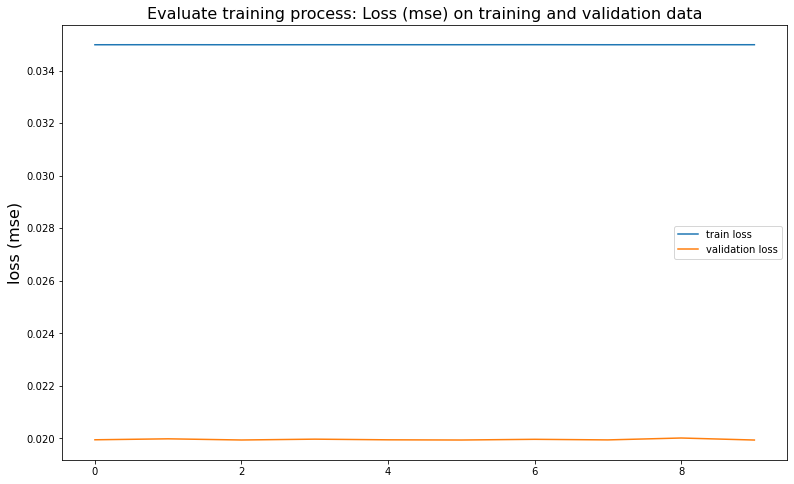

In [82]:
# Plot loss (mse) on train and validation data:
fig, axes = plt.subplots(1, 1, figsize=(13,8))
axes.set_title("Evaluate training process: Loss (mse) on training and validation data", fontsize=16)
axes.plot(history.history['loss'], label='train loss'), 
axes.plot(history.history['val_loss'], label='validation loss')
axes.set_ylabel("loss (mse)", fontsize=16)
axes.legend()
plt.show()


In [ ]:
# Get model predictions on training, validation and test data from trained model:
train_pred = model_MLP.predict(train_input)
val_pred = model_MLP.predict(val_input)
test_pred = model_MLP.predict(test_input)

### Discussion on baseline MLP model on dummy data

This tutorial shows first steps for setting up a basic multilayer perceptron.
The loss curves appear to be just flat. This tells us, that there is no real training progress.

--> We need to wait for the final data :-)